# Функция для подсчета Retention игроков мобильной игры

Задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Данные имеют следующую структуру:
- reg_data.csv – данные о времени регистрации id пользователя
- auth_data.csv – данные о времени захода пользователей в игру по id

Данные с 18-11-1998 по 23-09-2020.

In [1]:
# Импортируем необходимые библиотеки
import requests
from urllib.parse import urlencode

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
sns.set(style='whitegrid', rc={'figure.figsize':(11,6)})

## Функция retention()

In [2]:
def retention(reg_data,
              auth_data,
              start_date=None,
              weight_avg=False,
              y_limit=True,
              max_days=60,
              check_days=[]):
    """
    Функция рассчитывает retention. 
    - path_to_reg: df с временем регистраций;
    - path_to_auth: df с временем захода пользователей в игру;
    - start_date: первая дата для расчета ретеншен в формате "YYYY-MM-DD", по умолчанию минимальная дата;
    - weight_avg: расчет взвешенного среднего арифметического Retention по дням, если True. 
    По умолчанию False - расчет среднего арифметического.
    - y_limit (True/False): устанавливает ограничение максимального значения оси Y для удобства при низком retention,
    по умолчанию True;
    - max_days: количество дней для построения графика retention, по умолчанию max_days = 60;
    - check_days: указываются дни в формате списка для вывода информации по доле вернувшихся пользователей,
    по умолчанию check_days = [] и информация не выводится
    """
    
    # Переведем дату в формат datetime без времени
    reg_data['reg_ts'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.normalize()
    reg_data = reg_data.rename(columns={'reg_ts': 'reg_date'})
    auth_data['auth_ts'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.normalize()
    auth_data = auth_data.rename(columns={'auth_ts': 'auth_date'})
    
    # Для удобства поменяем местами столбцы
    auth_data = auth_data[['uid', 'auth_date']]
    
    # Объединим два датафрейма, т.о. auth_data будет содержать информацию о дате регистрации пользователя
    full_data = auth_data.merge(reg_data, how='left', on='uid')
    
    # Удалим повторные авторизации пользователей за день (если такие имеются)
    full_data = full_data.drop_duplicates(subset=['uid', 'auth_date'])
    
    # Добавим колонку с количеством дней после регистрации
    full_data['days_after_reg'] = (full_data['auth_date'] - full_data['reg_date']).dt.days
    
    # Сгруппируем данные по дню регистрации и количеству дней прошедших после регистрации
    # Т.о. найдем количество пользователей из каждой когорты, зашедших в приложение в определенный номер дня после регистрации
    
    # Определение даты начала расчетов
    # Если начальная дата не указана (start_date=None), считаем по всем данным

    if start_date is None: 
        start = reg_data['reg_date'].min()
    # Иначе указывается в ручную
    else:
        start = start_date

    # Считаем количество пользователей в каждой когорте в определенный день после регистрации
    retention = (full_data.query('reg_date >= @start')
                          .groupby(['reg_date', 'days_after_reg'], as_index=False)
                          .agg({'uid': 'count'})
                          .sort_values('reg_date'))
    retention['reg_date'] = retention['reg_date'].dt.date
    
    # Преобразуем данные в формат, где
    # - индекс = когорте (день регистраци),
    # - колонки = количетсво дней после регистраци,
    # - значения = количество пользователей
    retention_count = retention.pivot(index='reg_date', columns='days_after_reg', values='uid')
    reg_users = retention_count.reset_index()[0].to_list() # количество регистраций в когорте

    
    # Преобразуем значения в доли пользователей, для этого разделим все значения когорты на количество регистраций в данной когорте
    retention = (retention_count.div(reg_users, axis=0) * 100).round(2)

    # Задаем параметры для выводы таблицы Retention
    style_retention = (retention.iloc[-15:,:15].div(100)
                                .style
                                .set_caption('Retention последних 14 дней')  # добавляем подпись
                                .background_gradient(cmap='Blues')  # раскрашиваем ячейки по столбцам
                                .highlight_null('white')  # делаем белый фон для значений NaN
                                .format("{:.2%}", na_rep=""))  # числа форматируем как проценты, NaN заменяем на пустоту
    display(style_retention)

    # Расчет взвешенного среднего арифметического, если weight_avg=True
    if weight_avg:
        # Приобразуем df таким образом, чтобы кол-во колонок равнялось кол-ву строк
        # Для этого заполним значения для пропущенных дат и дней после регистрации нулями
        idy = pd.date_range(retention_count.index.min(), retention_count.index.max())
        retention_count = retention_count.reindex(labels=idy, fill_value=0)
        idx = list(i for i in range(retention_count.shape[0]))
        retention_count = retention_count.reindex(columns=idx, fill_value=0)
        # Количество регистраций в когорте
        cohort_users = retention_count.reset_index()[1].to_list()
        # Количество вернувшихся пользователей
        retention_users = retention_count.sum()
        # Считаем среднее взвешенное
        retention_avg = [100]
        for i in retention_users.index.to_list()[1:]:
            if sum(reg_users[:-i]) == 0:
                weight = 0
            else:
                weight = round((retention_users[i] / sum(reg_users[:-i]) * 100), 2)
            retention_avg.append(weight)
    else:
        # Иначе считаем среднее арифметическое
        retention_avg = retention.mean().round(2).to_list()
    
    
    # ГРАФИК
    # Если y_limit = True Устанавливаем ограничение максимального значения оси Y для удобства при низком retention
    # Макс.значние Y = макс.значение retention + 5, но не более 100
    # Первый день не учитывается, т.к. там всегда 100%
    if y_limit:
        y_lim = (round(max(retention_avg[1:max_days + 1]) + 5, 0)
                   if (round(max(retention_avg[1:max_days + 1]) + 5, 0)) <= 100 else 100)
    else:
        y_lim = 100
    
    # Строим линейный график по средним значения retention
    fig, ax = plt.subplots(1, figsize=(12, 5))
    sns.lineplot(retention_avg[:max_days + 1], ax=ax)
    ax.set(xlim=(0, None), ylim=(0, y_lim), xlabel='Дней после регистрации', ylabel=None)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
    fig.suptitle('Retention')
    plt.show()

    # # Выведем информацию по возврату пользователей в определенный день
    # day_retention = retention.mean()[check_day].mean().round(2)
    # print(f'{day_retention}% пользователей вернулось в игру в {check_day} день после регистрации')

    # Выведем информацию по возврату пользователей в указанные в check_days дни, если они указаны
    if check_days:
        # Отбираем нужные значения
        values = [str(retention_avg[i]) +'%' for i in check_days]
        # Создаем таблицу
        result_table = pd.DataFrame({'Retention': values}, index=[pd.to_timedelta(check_days, 'D')])
        # Выводим таблицу
        display(result_table)
        

In [5]:
%%time
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Ссылка на файл
public_key='https://disk.yandex.ru/d/zpxZihWeQjgd2Q'
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
# Считываем данные
reg_data = pd.read_csv(download_url, sep=';')

CPU times: total: 109 ms
Wall time: 16.7 s


In [6]:
%%time
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# Ссылка на файл
public_key='https://disk.yandex.ru/d/4PILm3Ay19cllQ'
# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
# Считываем данные
auth_data = pd.read_csv(download_url, sep=';')

CPU times: total: 1.33 s
Wall time: 56.4 s


## Примеры использования функции

days_after_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_date,,,,,,,,,,,,,,,
2020-09-09,100.00%,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%
2020-09-10,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%,
2020-09-11,100.00%,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,,
2020-09-12,100.00%,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,,
2020-09-13,100.00%,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,,
2020-09-14,100.00%,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,,
2020-09-15,100.00%,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,,
2020-09-16,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,,


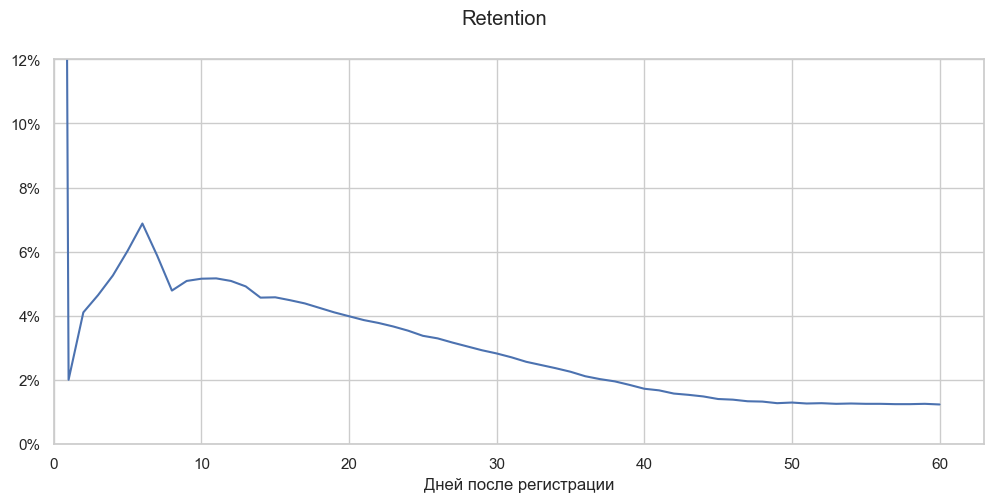

,Retention
0 days,100%
1 days,2.01%
7 days,5.88%
14 days,4.57%
30 days,2.83%


In [7]:
retention(reg_data,
          auth_data,
          check_days=[0, 1, 7, 14, 30],
          weight_avg=True)

days_after_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13
reg_date,,,,,,,,,,,,,,
2020-09-10,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%
2020-09-11,100.00%,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,
2020-09-12,100.00%,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,
2020-09-13,100.00%,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,
2020-09-14,100.00%,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,
2020-09-15,100.00%,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,
2020-09-16,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,
2020-09-18,100.00%,1.90%,4.54%,4.23%,5.21%,3.74%,,,,,,,,


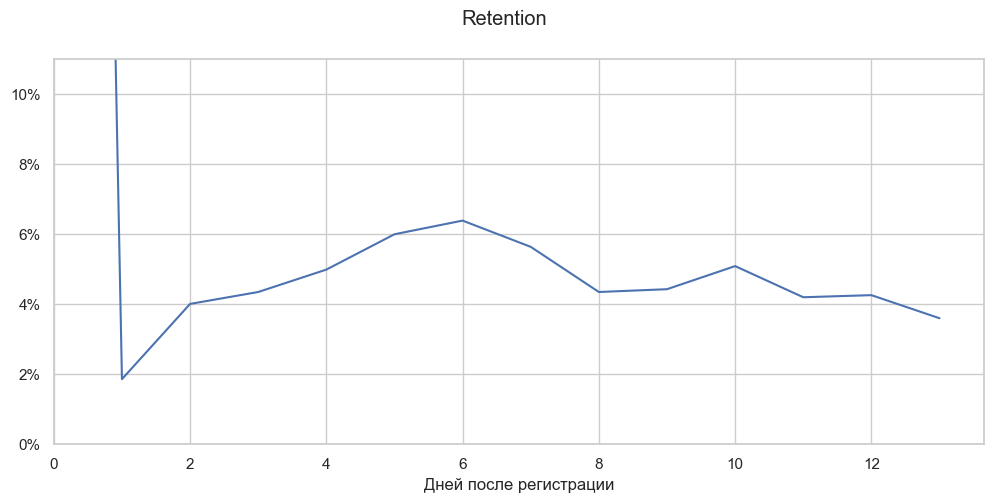

,Retention
0 days,100.0%
1 days,1.86%
2 days,4.01%
3 days,4.35%
4 days,4.99%
5 days,6.0%
6 days,6.39%
7 days,5.64%


In [8]:
retention(reg_data,
          auth_data,
          check_days=[0, 1, 2, 3, 4, 5, 6, 7],
          weight_avg=False,
          start_date="2020-09-10")

### Ниже приведен пример влияние малочисленных когорт на расчет Retention

days_after_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_date,,,,,,,,,,,,,,,
2020-09-09,100.00%,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%
2020-09-10,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%,
2020-09-11,100.00%,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,,
2020-09-12,100.00%,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,,
2020-09-13,100.00%,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,,
2020-09-14,100.00%,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,,
2020-09-15,100.00%,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,,
2020-09-16,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,,


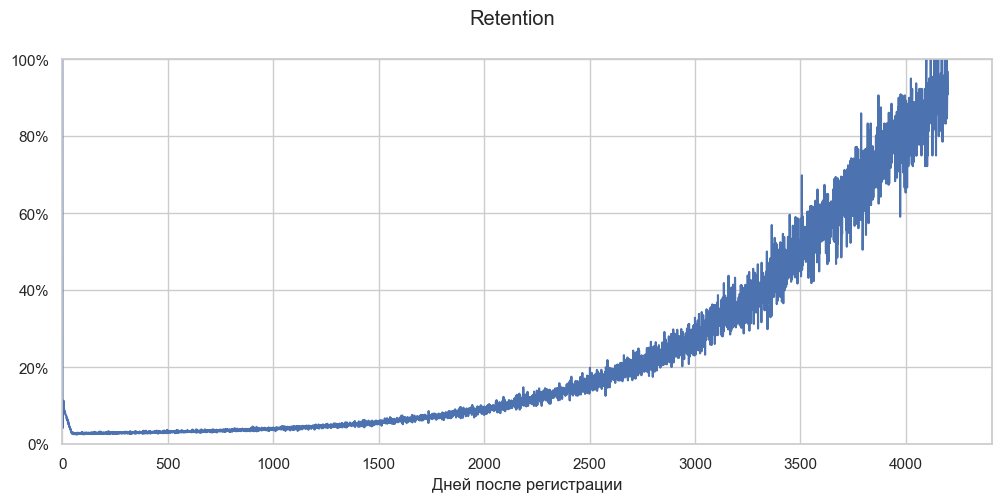

,Retention
0 days,100.0%
1 days,4.17%
7 days,9.74%
14 days,7.76%
30 days,5.45%


In [9]:
retention(reg_data,
          auth_data,
          check_days=[0, 1, 7, 14, 30],
          y_limit=False,
          weight_avg=False,
          max_days=4200)

### При использовании взвешенных средних, снижается влияение малых размеров когорт на расчеты

days_after_reg,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_date,,,,,,,,,,,,,,,
2020-09-09,100.00%,1.74%,3.24%,4.67%,5.72%,6.66%,5.72%,5.91%,4.36%,5.04%,3.73%,5.04%,4.79%,4.85%,2.43%
2020-09-10,100.00%,2.05%,4.29%,4.79%,4.23%,6.77%,6.28%,7.09%,4.85%,4.54%,5.66%,4.72%,5.22%,3.60%,
2020-09-11,100.00%,1.30%,4.03%,4.53%,5.65%,5.71%,6.70%,6.33%,4.40%,4.65%,5.40%,5.33%,3.29%,,
2020-09-12,100.00%,1.92%,3.84%,4.71%,4.65%,6.07%,6.57%,5.76%,5.27%,5.14%,5.70%,2.54%,,,
2020-09-13,100.00%,1.98%,4.08%,4.26%,5.13%,6.55%,6.49%,4.94%,4.70%,4.94%,3.58%,,,,
2020-09-14,100.00%,2.22%,3.83%,4.51%,5.31%,6.49%,6.98%,6.30%,4.45%,2.90%,,,,,
2020-09-15,100.00%,2.22%,4.07%,4.56%,6.04%,5.61%,6.90%,5.67%,2.46%,,,,,,
2020-09-16,100.00%,1.91%,4.25%,4.62%,4.68%,6.77%,6.95%,3.38%,,,,,,,
2020-09-17,100.00%,1.66%,4.30%,4.55%,5.47%,6.27%,4.24%,,,,,,,,


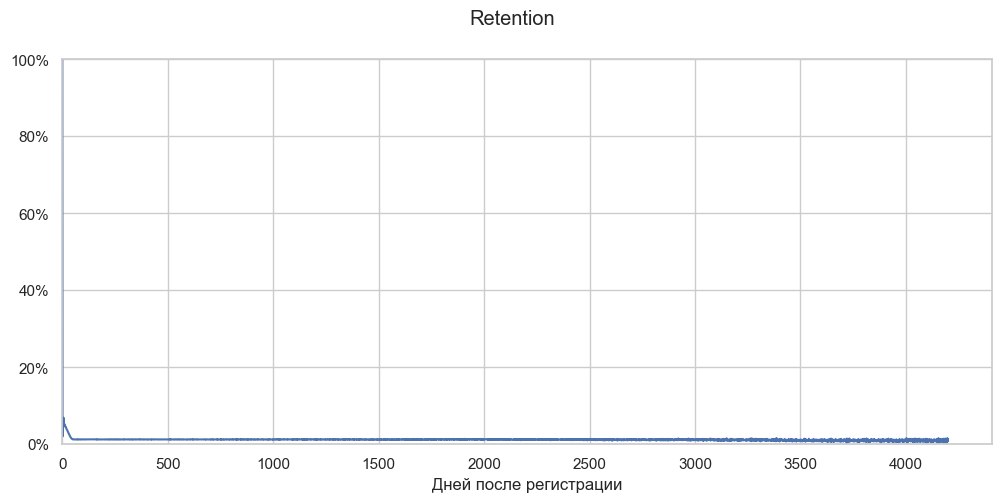

,Retention
0 days,100%
1 days,2.01%
7 days,5.88%
14 days,4.57%
30 days,2.83%


In [10]:
retention(reg_data,
          auth_data,
          check_days=[0, 1, 7, 14, 30],
          y_limit=False,
          weight_avg=True,
          max_days=4200)